In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import math
from prettytable import PrettyTable 
import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle
from tqdm import tqdm
import os
from collections import Counter

In [2]:
df = pd.read_csv("Corona_NLP_train.csv\Corona_NLP_train.csv",encoding='latin1')
df.iloc[50:55]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
50,3849,48801,"Washington, DC",16-03-2020,"""Everything weÂre seeing in the current COVID...",Extremely Negative
51,3850,48802,"Ohio, USA",16-03-2020,"Everyone is closed, but we remain open because...",Neutral
52,3851,48803,"Ogden, UT",16-03-2020,Why we stock up on water... cause utility comp...,Negative
53,3852,48804,NaN,16-03-2020,"Dear Coronavirus, \r\r\nI've been following so...",Positive
54,3853,48805,NaN,16-03-2020,Global food prices before the spread of COVID ...,Extremely Negative


In [4]:
top_loc = df['Location'].value_counts()
len(top_loc)

12220

In [6]:
clas = df['Sentiment'].value_counts()
clas

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

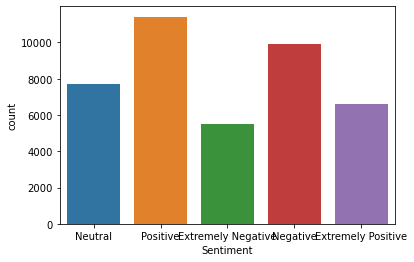

In [7]:
sns.countplot(df["Sentiment"])

(-1.1135203950263177,
 1.1113158145507724,
 -1.1332039018288786,
 1.1015811381823275)

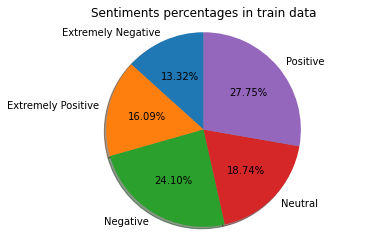

In [8]:
labels=['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']
sizes = [
         df[df['Sentiment'] == 'Extremely Negative'].shape[0], 
         df[df['Sentiment'] == 'Extremely Positive'].shape[0],
         df[df['Sentiment'] == 'Negative'].shape[0], 
         df[df['Sentiment'] == 'Neutral'].shape[0],
         df[df['Sentiment'] == 'Positive'].shape[0]
        ]
plt.pie(sizes,labels=labels, data=df, autopct='%1.2f%%', shadow=True, startangle=90)
plt.title("Sentiments percentages in train data")
plt.axis("equal")

In [9]:
#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
df['preprocessed_tweets']=df['OriginalTweet'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['OriginalTweet']=df['preprocessed_tweets'].apply(lambda x:remove_html(x))

In [11]:
# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
df['preprocessed_tweets']=df['OriginalTweet'].apply(lambda x:lower(x))


# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
df['OriginalTweet']=df['preprocessed_tweets'].apply(lambda x:remove_num(x))

In [12]:
#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
df['preprocessed_tweets']=df['OriginalTweet'].apply(lambda x:punct_remove(x))



def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['OriginalTweet']=df['preprocessed_tweets'].apply(lambda x:remove_stopwords(x))

In [13]:
#Remove mentions and hashtags
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
df['preprocessed_tweets']=df['OriginalTweet'].apply(lambda x:remove_mention(x))
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
df['OriginalTweet']=df['preprocessed_tweets'].apply(lambda x:remove_hash(x))

In [14]:
#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
df['preprocessed_tweets']=df['OriginalTweet'].apply(lambda x:remove_space(x))

df = df.drop(columns=['preprocessed_tweets'])

In [15]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,menyrbie phil_gahan chrisitv,Neutral
1,3800,48752,UK,16-03-2020,advice talk neighbours family exchange phone n...,Positive
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths give elderly ...,Positive
3,3802,48754,NaN,16-03-2020,food stock one empty please dont panic enough ...,Positive
4,3803,48755,NaN,16-03-2020,ready go supermarket covid outbreak im paranoi...,Extremely Negative


In [16]:
print(df['Location'].isnull().values.any())
print("number of nan values",df['Location'].isnull().values.sum())

True
number of nan values 8590


In [17]:
#https://stackoverflow.com/questions/60701329/different-ways-to-pre-process-date-in-machine-learning-using-python
import datetime
pre_tweetat = []
origin = datetime.datetime(2020,3,16)
for i in tqdm(df["TweetAt"]):
    days = (datetime.datetime.strptime(i, '%d-%m-%Y') - origin).days
    pre_tweetat.append(days)
df["pre_tweetat"] = pre_tweetat


100%|█████████████████████████████████████████████████████████████████████████| 41157/41157 [00:01<00:00, 30859.72it/s]


In [18]:
df.tail(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,pre_tweetat
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,airline pilots offering stock supermarket shel...,Neutral,29
41153,44952,89904,NaN,14-04-2020,response complaint provided citing covid relat...,Extremely Negative,29
41154,44953,89905,NaN,14-04-2020,know itâs getting tough kameronwilds rationing...,Positive,29
41155,44954,89906,NaN,14-04-2020,wrong smell hand sanitizer starting turn coron...,Neutral,29
41156,44955,89907,i love you so much || he/him,14-04-2020,tartiicat well newused rift going amazon rn al...,Negative,29


In [19]:
sentiment_pre = []
for i in tqdm(df["Sentiment"]):
    if i == 'Extremely Positive':
        sentiment_pre.append(1)
    elif i == 'Positive':
        sentiment_pre.append(1)
    elif i == 'Neutral':
        sentiment_pre.append('N')
    elif i == 'Negative':
        sentiment_pre.append(0)
    elif i == 'Extremely Negative':
        sentiment_pre.append(0)    
df["sentiment_pre"] = sentiment_pre

df = df[df.sentiment_pre != 'N']
df.sentiment_pre.value_counts()

100%|████████████████████████████████████████████████████████████████████████| 41157/41157 [00:00<00:00, 651392.86it/s]


1    18046
0    15398
Name: sentiment_pre, dtype: int64

In [20]:
df = df.drop(["ScreenName"],axis=1)
df = df.drop(["UserName"],axis=1)
df = df.drop(["TweetAt"],axis=1)
df = df.drop(["Sentiment"],axis=1)
df = df.drop(["Location"],axis=1)


In [21]:
df

,OriginalTweet,pre_tweetat,sentiment_pre
1,advice talk neighbours family exchange phone n...,0,1
2,coronavirus australia woolworths give elderly ...,0,1
3,food stock one empty please dont panic enough ...,0,1
4,ready go supermarket covid outbreak im paranoi...,0,0
5,news regionâs first confirmed covid case came ...,0,1
...,...,...,...
41150,never weâd situation amp world going supermark...,29,1
41151,mrsilverscott definitely man feel like fall ne...,29,1
41153,response complaint provided citing covid relat...,29,0
41154,know itâs getting tough kameronwilds rationing...,29,1


Splitting the data into **X** and **Y**

In [22]:
Y=df['sentiment_pre'].values
Y=Y.astype('int')                 
X=df.drop(["sentiment_pre"],axis=1)
len(Y)

33444

Train Test Split

In [23]:
#splitting the data and in this I will use RandomSearchCV therefore will only split into xtrain and xtest
# train test split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,stratify=Y)
#X_train, X_cv, Y_train, y_cv = train_test_split(X_train, Y_train, test_size=0.33, stratify=Y_train)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
#print(X_cv.shape,y_cv.shape)

(23410, 2) (23410,)
(10034, 2) (10034,)


**Encoding the Columns**

In [24]:
#Encoding the preprocessed_tweets column
model_tweets = CountVectorizer(max_features=41157,ngram_range=(1,2),min_df=10)
model_tweets.fit(X_train["OriginalTweet"].values)

X_train_tweet_bow = model_tweets.transform(X_train["OriginalTweet"].values)
X_test_tweet_bow = model_tweets.transform(X_test["OriginalTweet"].values)

print(X_train_tweet_bow.shape, Y_train.shape)
print(X_test_tweet_bow.shape, Y_test.shape)


(23410, 7126) (23410,)
(10034, 7126) (10034,)


In [25]:
#Encoding Numerical features : pre_tweetat
model_time = Normalizer()
model_time.fit(X_train["pre_tweetat"].values.reshape(1,-1))
model_time2 = Normalizer()
model_time2.fit(X_test["pre_tweetat"].values.reshape(1,-1))

X_train_time = model_time.transform(X_train["pre_tweetat"].values.reshape(1,-1)).T
X_test_time = model_time2.transform(X_test["pre_tweetat"].values.reshape(1,-1)).T

print(X_train_time.shape, Y_train.shape)
print(X_test_time.shape, Y_test.shape)

(23410, 1) (23410,)
(10034, 1) (10034,)


In [26]:
#Concatinating all the features

X_tr = hstack((X_train_tweet_bow,X_train_time)).tocsr()
X_te = hstack((X_test_tweet_bow,X_test_time)).tocsr()

print(X_tr.shape, Y_train.shape)

print(X_te.shape, Y_test.shape)

(23410, 7127) (23410,)
(10034, 7127) (10034,)


In [27]:
#Appling Multinomial NB: BOW featurization

def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

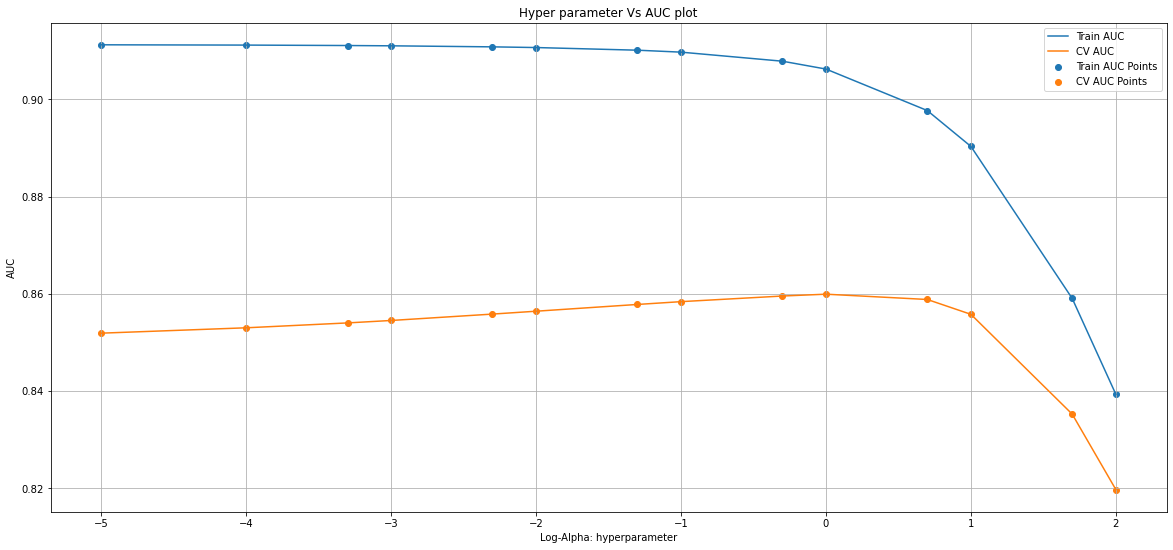

In [28]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

nbayes = MultinomialNB(class_prior = [0.5,0.5],fit_prior=False)
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
clf = GridSearchCV(nbayes,parameters,cv=10, scoring='roc_auc',return_train_score=True,n_jobs=-1)
clf.fit(X_tr,Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(["param_alpha"])

train_auc = results["mean_train_score"]
cv_auc = results["mean_test_score"]

alph = results["param_alpha"]             
log_alp=[]
for i in range(0,len(alph),1):
    l=math.log10(alph[i])
    log_alp.append(l)
log_alp.sort()

plt.figure(figsize=(20,9))

plt.plot(log_alp,train_auc,label='Train AUC')
plt.plot(log_alp,cv_auc,label='CV AUC')
plt.scatter(log_alp,train_auc,label='Train AUC Points')
plt.scatter(log_alp,cv_auc,label='CV AUC Points')
plt.legend()
plt.xlabel("Log-Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")

plt.grid()
plt.show()


In [29]:
#printing the results for better observation
results[["param_alpha","mean_test_score","mean_train_score"]]

,param_alpha,mean_test_score,mean_train_score
0,1e-05,0.851870,0.911241
2,0.0001,0.852975,0.911180
1,0.0005,0.853979,0.911091
4,0.001,0.854483,0.911031
3,0.005,0.855798,0.910817
6,0.01,0.856390,0.910675
5,0.05,0.857782,0.910129
7,0.1,0.858358,0.909727
8,0.5,0.859516,0.907865
9,1,0.859895,0.906245


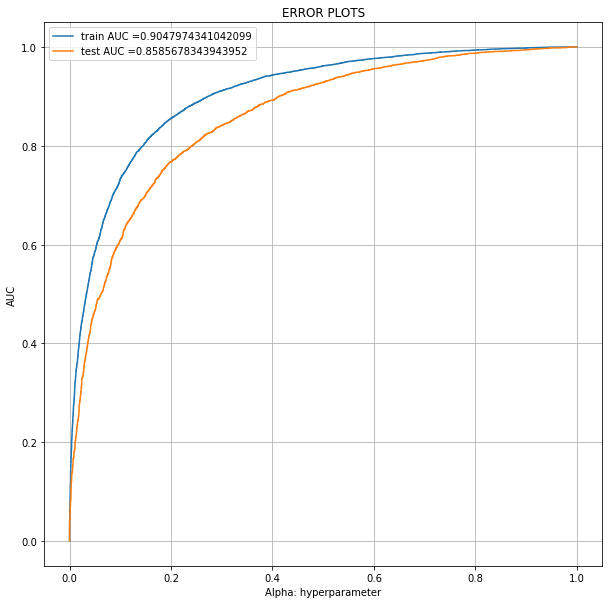

In [30]:
best_alpha = 0.5
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

multi_nb = MultinomialNB(alpha=best_alpha,class_prior=[0.5,0.5])
multi_nb.fit(X_tr,Y_train)

y_train_pred = batch_predict(multi_nb,X_tr)
y_test_pred = batch_predict(multi_nb,X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)


plt.figure(figsize=(10,10))

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [31]:
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.688662715232434 for threshold 0.52
Train confusion matrix


Text(33.0, 0.5, 'Actual')

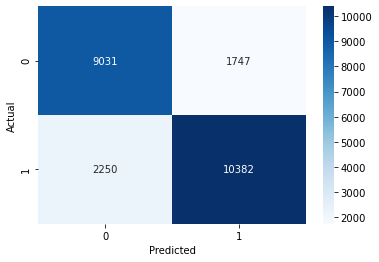

In [32]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print('='*50)
print("Train confusion matrix")
print('='*50)
train_cm = confusion_matrix(Y_train, predict_with_best_t(y_train_pred, best_t))
sns.heatmap(train_cm, annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")

Test confusion matrix


Text(33.0, 0.5, 'Actual')

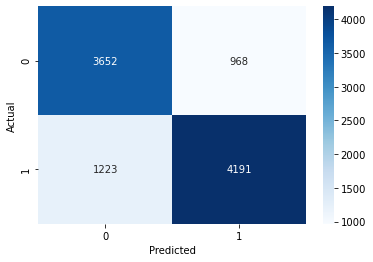

In [33]:
print('='*50)
print("Test confusion matrix")
print('='*50)
test_cm = confusion_matrix(Y_test, predict_with_best_t(y_test_pred, best_t))
sns.heatmap(test_cm, annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [34]:
#Extracting True Positives for WordClouds

pred1 = predict_with_best_t(y_test_pred, best_t)
fal_pos = []
for i in range(len(Y_test)):
    if (Y_test[i]==1) and (pred1[i]==1):
        fal_pos.append(i)


#extracting the Tweets from X_test
pos_tweets = []
for i in tqdm(fal_pos):
    pos_tweets.append(X_test['OriginalTweet'].values[i])
    


100%|███████████████████████████████████████████████████████████████████████████| 4191/4191 [00:00<00:00, 48804.42it/s]


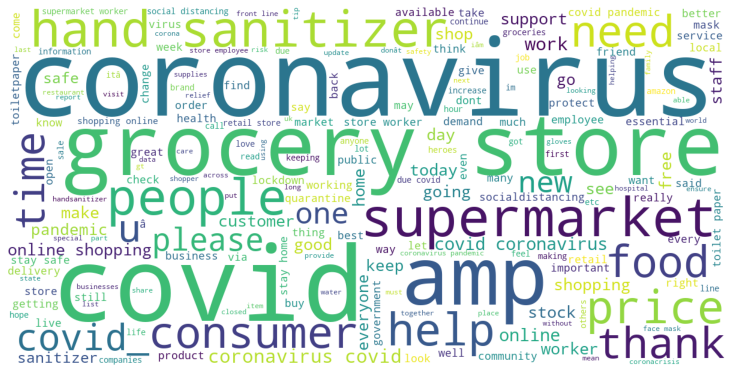

In [36]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS

comment_words = ''
stopwords = set(STOPWORDS)
  
# iterate through the csv file
for val in pos_tweets:
       
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1200, height = 600,
                background_color ='White',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (10, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [37]:
#Extracting True Negatives for WordClouds

pred0 = predict_with_best_t(y_test_pred, best_t)
tru_neg = []
for i in range(len(Y_test)):
    if (Y_test[i]==0) and (pred0[i]==0):
        tru_neg.append(i)


#extracting the Tweets from X_test
neg_tweets = []
for i in tqdm(tru_neg):
    neg_tweets.append(X_test['OriginalTweet'].values[i])
    


100%|██████████████████████████████████████████████████████████████████████████| 3652/3652 [00:00<00:00, 139797.37it/s]


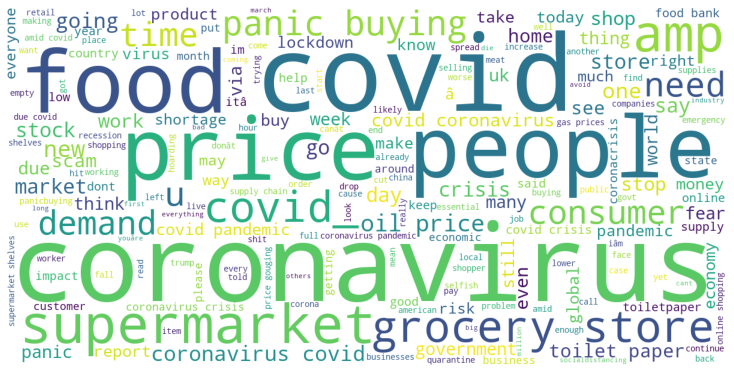

In [110]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
    
comment_words = ''
stopwords = set(STOPWORDS)
  
# iterate through the csv file
for val in neg_tweets:
       
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1200, height = 600,
                background_color ='White',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (10, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [38]:
#Extracting the top 20 Features of Postive and the Negative Class

#https://imgur.com/mWvE7gj
top_feat = multi_nb.feature_log_prob_
sort_tf=np.argsort(top_feat)


neg_feat = sort_tf[0]
neg_feat = neg_feat[::-1][:20]         #top 20 negative features
pos_feat = sort_tf[1]
pos_feat = pos_feat[::-1][:20]         #top 20 positive features


l = []
l.extend(model_tweets.get_feature_names())
l.append('pre_tweetat')


print("-"*100)
print("Top 20 Positive features")
print("-"*100)
for i in pos_feat:
    print(l[i])
    
print("-"*100)
print("Top 20 Negative features")
print("-"*100)
for j in neg_feat:
    print(l[j])

----------------------------------------------------------------------------------------------------
Top 20 Positive features
----------------------------------------------------------------------------------------------------
covid
coronavirus
store
grocery
supermarket
prices
food
amp
grocery store
people
consumer
online
shopping
help
sanitizer
hand
like
workers
pandemic
get
----------------------------------------------------------------------------------------------------
Top 20 Negative features
----------------------------------------------------------------------------------------------------
covid
coronavirus
prices
food
supermarket
people
store
grocery
panic
amp
grocery store
consumer
crisis
demand
pandemic
covid_
buying
oil
need
get
